<a href="https://colab.research.google.com/github/IvaStival/DataScience/blob/master/RCNN/code/RCNN_Colab_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout
from tensorflow.keras import Model, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
import cv2
import zipfile
import shutil

In [2]:
def unzipFolders(file_path, destiny):
  with zipfile.ZipFile(file_path, "r") as z:
    z.extractall(destiny)

In [3]:
def showImages(img_path, csv_path, filename):
    csv_filename = filename.split('.')[0] + ".csv"

    image = cv2.imread(os.path.join(img_path, filename))
    df = pd.read_csv(os.path.join(csv_path, csv_filename))

    gtvalues = []
    plt.imshow(image)
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append({"x1":x1, "x2":x2, "y1":y1, "y2":y2})
        cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
    plt.figure()
    plt.imshow(image)
    

In [4]:
path = "/content/drive/MyDrive/DataScience/RCNN"

In [5]:
image_zip = f"{path}/dataset/Images.zip"
csv_zip = f"{path}/dataset/Airplanes_Annotations.zip"
destiny = f"{path}/dataset"

# unzipFolders(image_zip, destiny)
# unzipFolders(csv_zip, destiny)

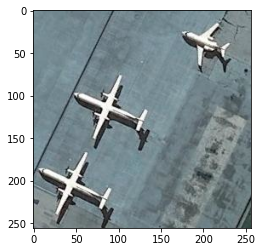

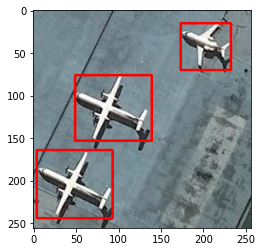

In [6]:
showImages(f"{path}/dataset/Images", f"{path}/dataset/Airplanes_Annotations", "airplane_001.jpg")

In [7]:
def get_iou(bb1, bb2):
    assert bb1["x1"] < bb1["x2"]
    assert bb1["y1"] < bb1["y2"]
    assert bb2["x1"] < bb2["x2"]
    assert bb2["y1"] < bb2["y2"]

    x_left   = max(bb1["x1"], bb2["x1"])
    y_top    = max(bb1["y1"], bb2["y1"])
    x_right  = min(bb1["x2"], bb2["x2"])
    y_bottom = min(bb1["y2"], bb2["y2"])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    interseption_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1["x2"] - bb1["x1"]) * (bb1["y2"] - bb1["y1"])
    bb2_area = (bb2["x2"] - bb2["x1"]) * (bb2["y2"] - bb2["y1"])

    iou = interseption_area / float(bb1_area + bb2_area - interseption_area)

    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou
 

In [8]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def imagePreProcessor(path, csv_path, filename, e, air_counter, not_air_counter, folder_path):
    
    train_images = []
    
    csv_filename = filename.split('.')[0] + ".csv"
    print(f"{e} {filename}")

    image = cv2.imread(os.path.join(path, filename))
    df = pd.read_csv(os.path.join(csv_path, csv_filename))

    gtvalues = []

    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append({"x1":x1, "x2":x2, "y1":y1, "y2":y2})

    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()

    counter = 0
    false_counter = 0
    flag = 0
    fflag = 0
    bflag = 0

    for e, result in enumerate(ssresults):
        if e < 2000 and flag == 0:
            for gtval in gtvalues:
                x, y, w, h = result

                iou = get_iou(gtval, {"x1":x, "x2":x+w, "y1":y, "y2":y+h})

                if counter < 30:
                    if iou > 0.70:
                        timage = imout[y:y+h, x:x+w]
                        resized = cv2.resize(timage,  (224, 224), interpolation = cv2.INTER_AREA)
                        file_name = f"{folder_path}/airplane_{air_counter}.jpg"
                        cv2.imwrite(file_name, resized)
                        train_images.append(file_name)                        
                        air_counter += 1
                        counter += 1
                else:
                    fflag = 1
                if false_counter < 30:
                    if iou < 0.3:
                        timage = imout[y:y+h, x:x+w]
                        resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
                        file_name = f"{folder_path}/not_airplane_{not_air_counter}.jpg"
                        cv2.imwrite(file_name, resized)
                        train_images.append(file_name)                        
                        not_air_counter += 1
                        false_counter += 1
                else:
                    bflag = 1
            if fflag == 1 and bflag == 1:
                print("inside")
                flag = 1
                
    return (train_images, air_counter, not_air_counter)

In [9]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == "binary":
            return np.hstack((Y, 1-Y))
        else:
            return Y
        
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == "binary":
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [10]:
def runImagePre(path, csv_path):
    main_path = "/content/drive/MyDrive/DataScience/RCNN"
    new_image_path = main_path + "/dataset/preImages"
    
    try:
        os.mkdir(new_image_path)
    except Exception as e:
        print(f"Error: {e}")
        
    
    images_list = []
    
    air_counter = 0
    not_air_counter = 0    
    
    for e, i in enumerate(os.listdir(path)):
        try:
            if i.startswith("airplane"):
                temp_images, air_counter, not_air_counter = imagePreProcessor(path, csv_path, i, e, air_counter, not_air_counter, new_image_path)
                images_list += temp_images
        except Exception as e:
            print(e)
            print("Error")
            continue
        
    return images_list



In [11]:
def createNewExtructureFolder(train_images, path):
    # CREATE train Folder
    try:
        os.mkdir(new_image_path+"/train")
        os.mkdir(new_image_path+"/test")        
    except Exception as e:
        print(f"Message: {e}")
        
    try:
        os.mkdir(new_image_path+"/train/airplane")
        os.mkdir(new_image_path+"/train/not_airplane")
    except Exception as e:
        print(f"Message: {e}")
        
    try:
        os.mkdir(new_image_path+"/test/airplane")
        os.mkdir(new_image_path+"/test/not_airplane")
    except Exception as e:
        print(f"Message: {e}")
        
    df = pd.DataFrame(train_images)
    X_train, X_test = train_test_split(df, test_size=0.3)
    

    for idx, path in X_train.iterrows():
        if "not" in path[0].split("/")[-1]:
            shutil.move(path[0], new_image_path+"/train/not_airplane")
        else:
            shutil.move(path[0], new_image_path+"/train/airplane")
            
    for idx, path in X_test.iterrows():
        if "not" in path[0].split("/")[-1]:
            shutil.move(path[0], new_image_path+"/test/not_airplane")
        else:
            shutil.move(path[0], new_image_path+"/test/airplane")

In [12]:
path = "/content/drive/MyDrive/DataScience/RCNN/dataset/Images"
csv_path = "/content/drive/MyDrive/DataScience/RCNN/dataset/Airplanes_Annotations"

train_images = runImagePre(path, csv_path)

Error: [Errno 17] File exists: '/content/drive/MyDrive/DataScience/RCNN/dataset/preImages'
0 airplane_280.jpg
1 airplane_519.jpg
2 airplane_531.jpg
3 airplane_257.jpg
4 airplane_243.jpg
5 airplane_525.jpg
6 airplane_096.jpg
inside
7 airplane_082.jpg
8 airplane_069.jpg
10 airplane_055.jpg
11 airplane_041.jpg
inside
13 airplane_026.jpg
14 airplane_032.jpg
15 airplane_218.jpg
16 airplane_224.jpg
17 airplane_542.jpg
18 airplane_556.jpg
19 airplane_230.jpg
20 airplane_581.jpg
21 airplane_595.jpg
22 airplane_378.jpg
23 airplane_350.jpg
24 airplane_436.jpg
25 airplane_422.jpg
26 airplane_344.jpg
27 airplane_393.jpg
28 airplane_387.jpg
29 airplane_608.jpg
30 airplane_634.jpg
31 airplane_152.jpg
32 airplane_146.jpg
33 airplane_620.jpg
34 airplane_191.jpg
35 airplane_185.jpg
36 airplane_184.jpg
37 airplane_190.jpg
inside
38 airplane_147.jpg
39 airplane_621.jpg
inside
40 airplane_635.jpg
41 airplane_153.jpg
42 airplane_609.jpg
44 airplane_386.jpg
45 airplane_392.jpg
46 airplane_423.jpg
47 airplan

In [13]:
main_path = path = "/content/drive/MyDrive/DataScience/RCNN"
new_image_path = main_path + "/dataset/preImages"

createNewExtructureFolder(train_images, new_image_path)

In [16]:
def run(train_images):

    
#     train_images, train_labels = imageRecognition(path, csv_path, "airplane_001.jpg", 1)
#     for i in train_images:
#         plt.imshow(i)
#         plt.show()


    vggmodel = VGG16(weights="imagenet", include_top = True)

    for layers in (vggmodel.layers)[:15]:
        layers.trainable = False

    X = vggmodel.layers[-2].output
    predictions = Dense(2, activation="softmax")(X)
    model_final = Model(vggmodel.input, predictions)
    
    opt = Adam(learning_rate = 0.0001)
    model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics = ["accuracy"])
    model_final.summary()
    
#     lenc = MyLabelBinarizer()
#     Y = lenc.fit_transform(Y_new)
    
    trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    traindata = trdata.flow_from_directory("/content/drive/MyDrive/DataScience/RCNN/dataset/preImages/train", target_size=(224, 224))
    
    tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    testdata = tsdata.flow_from_directory("/content/drive/MyDrive/DataScience/RCNN/dataset/preImages/test", target_size=(224, 224))
    
    checkpoint = ModelCheckpoint("/content/drive/MyDrive/DataScience/RCNN/models/ieeecnn_vgg16_1.h5", monitor="accuracy", verbose=1, save_best_only=True, save_weights_only=False, mode="auto", period=1)
    
    early = EarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1, mode="auto")
    
    hist = model_final.fit(traindata, steps_per_epoch=10, epochs=500, validation_data=testdata, validation_steps=2, callbacks=[checkpoint, early])
    model_final.save("/content/drive/MyDrive/DataScience/RCNN/models/rcnn_test_model.h5")
    return model_final


In [17]:
model = run(train_images)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [18]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def predictImage(path, filename, model):
    predicted = {}
    
    image = cv2.imread(os.path.join(path, filename))
    
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()
    
    for e, result in enumerate(ssresults):
        x,y,w,h = result;
        timage = imout[y:y+h, x:x+w]
        resized = cv2.resize(timage,  (224, 224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        prediction = model.predict(img)
#         print(prediction)
        if prediction[0][0] > 0.70:
            cv2.rectangle(imout, (x,y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

    plt.figure()
    plt.imshow(imout)
    plt.show()

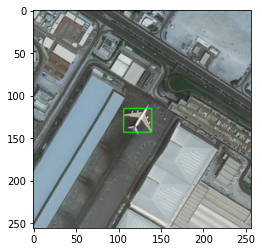

In [24]:
predictImage("/content/drive/MyDrive/DataScience/RCNN/dataset/Images", "428492.jpg", model)